<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

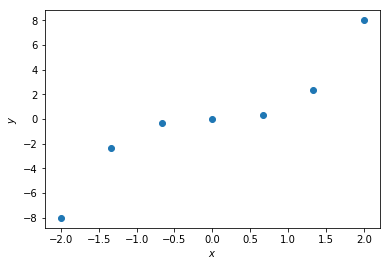

In [5]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

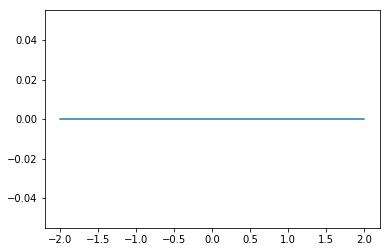

In [23]:
yy = lambda xx: 0

#plt.plot([[i, yy(i)] for i in np.linspace(-2, 2, 100)])
plt.plot(np.linspace(-2, 2, 100), [yy(i) for i in np.linspace(-2, 2, 100)])

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

(7, 1) (7,) (1000, 1) (1000,)


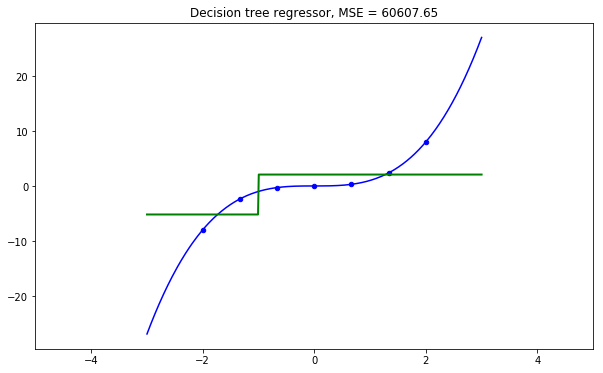

In [35]:
n_train = 150        
n_test = 1000       
noise = 0.1

def f(x):
    x = x.ravel()
    return x ** 3
def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 6 - 3
    X = np.sort(X).ravel()
    y = X ** 3
    np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

X_train, y_train = X.reshape(-1,1), y
X_test, y_test = generate(n_samples=n_test, noise=noise)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

from sklearn.tree import DecisionTreeRegressor

reg_tree = DecisionTreeRegressor(max_depth=1, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - reg_tree_pred) ** 2))
plt.show()

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [40]:
def regression_var_criterion(X, t): #y, t):
    xl = sum(i < t for i in X)
    xr = sum(i > t for i in X)
    x = 1
    
    d = lambda x: sum((j ** 3 - sum(i ** 3 for i in x)) ** 2 for j in x)
    
    dxl = []
    dxr = []
    
    for i in X:
        if i < t:
            dxl.append(i)
        elif i > t:
            dxr.append(i)
        else:
            dx = d([i,])
    
    dl = d(dxl)
    dr = d(dxr)
    
    return dx - xl * dl - xr * dr

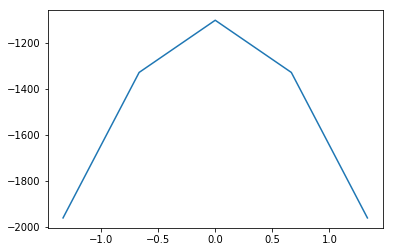

In [45]:
xx = X[1:-1] #np.linspace(-1.9, 1.9, 10):
yy = [regression_var_criterion(X, i) for i in xx]
plt.plot(xx, yy)

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

(7, 1) (7,) (1000, 1) (1000,)


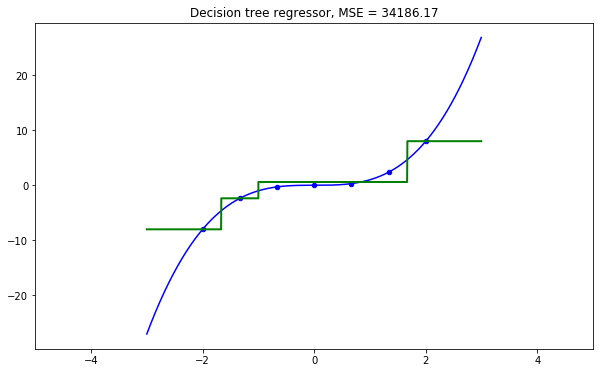

In [50]:
n_train = 150        
n_test = 1000       
noise = 0.1

def f(x):
    x = x.ravel()
    return x ** 3
def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 6 - 3
    X = np.sort(X).ravel()
    y = X ** 3
    np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

X_train, y_train = X.reshape(-1,1), y
X_test, y_test = generate(n_samples=n_test, noise=noise)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

from sklearn.tree import DecisionTreeRegressor

reg_tree = DecisionTreeRegressor(max_depth=2, random_state=7)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - reg_tree_pred) ** 2))
plt.show()

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [84]:
df = pd.read_csv('data/mlbootcamp5_train.csv', index_col='id', sep=';')

In [67]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [85]:
df['age'] = df['age'] // 365.25
#for i in df.values: print(i['gluc']) #df['gluc_one'] = True if df['']

gluc = pd.get_dummies(df['gluc'], prefix='gluc')
df['gluc_1'] = gluc['gluc_1']
df['gluc_2'] = gluc['gluc_2']
df['gluc_3'] = gluc['gluc_3']

gluc = pd.get_dummies(df['cholesterol'], prefix='cholesterol')
df['cholesterol_1'] = gluc['cholesterol_1']
df['cholesterol_2'] = gluc['cholesterol_2']
df['cholesterol_3'] = gluc['cholesterol_3']

df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,gluc_1,gluc_2,gluc_3,cholesterol_1,cholesterol_2,cholesterol_3
id,,,,,,,,,,,,,,,,,,
0,50.0,2,168,62.0,110,80,1,1,0,0,1,0,1,0,0,1,0,0
1,55.0,1,156,85.0,140,90,3,1,0,0,1,1,1,0,0,0,0,1
2,51.0,1,165,64.0,130,70,3,1,0,0,0,1,1,0,0,0,0,1
3,48.0,2,169,82.0,150,100,1,1,0,0,1,1,1,0,0,1,0,0
4,47.0,1,156,56.0,100,60,1,1,0,0,0,0,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [86]:
y = df['cardio']
df.drop(['cardio', 'gluc', 'cholesterol'], axis=1, inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(df.values, y, test_size=0.3, random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [90]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

tree_pred = tree.predict(X_valid)
print('!', accuracy_score(y_valid, tree_pred))

# from sklearn.model_selection import GridSearchCV, cross_val_score
# #tree_params = {'max_depth': range(1,11), 'max_features': range(4,19)}
# tree_grid = GridSearchCV(tree) #, tree_params, cv=5, n_jobs=-1, verbose=True)
# tree_grid.fit(X_train, y_train) 

export_graphviz(tree, feature_names=df.columns, out_file='cardio_tree.dot', filled=True) #_pred.best_estimator_
!dot -Tpng cardio_tree.dot -o cardio_tree.png

! 0.7212857142857143
/bin/sh: dot: command not found


**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [91]:
from sklearn.metrics import accuracy_score

tree_pred = tree.predict(X_valid)
print('!', accuracy_score(y_valid, tree_pred))

! 0.7212857142857143


Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [97]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)
accuracy_score(y_valid, tree_grid.predict(X_valid))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.8s finished


0.7256190476190476

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


2 - 0.7101428571428572
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.5s finished


3 - 0.7212857142857143
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.6s finished


4 - 0.727047619047619
Fitting 5 folds for each of 4 candidates, totalling 20 fits
5 - 0.7255714285714285
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done  18 out of  25 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.8s finished


6 - 0.7256190476190476
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.0s finished


7 - 0.7256190476190476
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.2s finished


8 - 0.7256190476190476
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.5s finished


9 - 0.7256190476190476
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    1.4s remaining:    0.3s


10 - 0.7256190476190476


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.6s finished


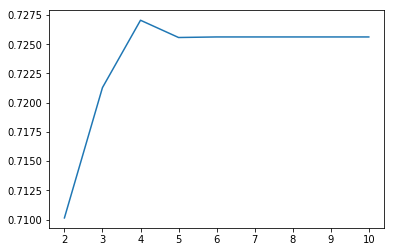

In [106]:
yy = []

for i in range(2, 11):
    tree_grid = GridSearchCV(tree, {'max_depth': list(range(2, i+1))}, cv=5, n_jobs=-1, verbose=True)
    tree_grid.fit(X_train, y_train)
    yy.append(accuracy_score(y_valid, tree_grid.predict(X_valid)))
    print(i, '-', yy[-1])

plt.plot(list(range(2, 11)), yy)

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [105]:
tree_grid.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  38 out of  45 | elapsed:    1.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    2.0s finished


{'max_depth': 6}

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [143]:
df = pd.read_csv('data/mlbootcamp5_train.csv', index_col='id', sep=';')

df['age'] = df['age'] // 365.25

gluc = pd.get_dummies(df['cholesterol'], prefix='cholesterol')
df['cholesterol_1'] = gluc['cholesterol_1']
df['cholesterol_2'] = gluc['cholesterol_2']
df['cholesterol_3'] = gluc['cholesterol_3']

df.drop(['cholesterol', 'gluc'], axis=1, inplace=True)

In [144]:
df2 = df[:]
#df2['cardio'] = y
#df2 = df2[(df2['age'] >= 45) & (df2['age'] < 65) & (df2['ap_hi'] >= 120) & (df2['ap_hi'] < 180)]
#df2.apply(lambda x: x['age']=1 if 45<=x['age']) #df['age'].map({})

age = pd.get_dummies(df2['age'], prefix='age')
df2['age_1'] = age['age_45.0'] | age['age_46.0'] | age['age_47.0'] | age['age_48.0'] | age['age_49.0']
df2['age_2'] = age['age_50.0'] | age['age_51.0'] | age['age_52.0'] | age['age_53.0'] | age['age_54.0']
df2['age_3'] = age['age_55.0'] | age['age_56.0'] | age['age_57.0'] | age['age_58.0'] | age['age_59.0']
df2['age_4'] = age['age_60.0'] | age['age_61.0'] | age['age_62.0'] | age['age_63.0'] | age['age_64.0']

age = pd.get_dummies(df2['ap_hi'], prefix='ap_hi')
df2['ap_hi_1'] = age['ap_hi_120'] | age['ap_hi_121'] | age['ap_hi_122'] | age['ap_hi_123'] | age['ap_hi_124'] | age['ap_hi_125'] | age['ap_hi_126'] | age['ap_hi_127'] | age['ap_hi_128'] | age['ap_hi_129'] | age['ap_hi_130'] | age['ap_hi_131'] | age['ap_hi_132'] | age['ap_hi_133'] | age['ap_hi_134'] | age['ap_hi_135'] | age['ap_hi_136'] | age['ap_hi_137'] | age['ap_hi_138'] | age['ap_hi_139']
df2['ap_hi_2'] = age['ap_hi_140'] | age['ap_hi_141'] | age['ap_hi_142'] | age['ap_hi_143'] | age['ap_hi_144'] | age['ap_hi_145'] | age['ap_hi_146'] | age['ap_hi_147'] | age['ap_hi_148'] | age['ap_hi_149'] | age['ap_hi_150'] | age['ap_hi_151'] | age['ap_hi_152'] | age['ap_hi_153'] | age['ap_hi_154'] | age['ap_hi_155'] | age['ap_hi_156'] | age['ap_hi_157'] | age['ap_hi_158'] | age['ap_hi_159']
df2['ap_hi_3'] = age['ap_hi_160'] | age['ap_hi_161'] | age['ap_hi_162'] | age['ap_hi_163'] | age['ap_hi_164'] | age['ap_hi_165'] | age['ap_hi_166'] | age['ap_hi_167'] | age['ap_hi_168'] | age['ap_hi_169'] | age['ap_hi_170'] | age['ap_hi_171'] | age['ap_hi_172'] | age['ap_hi_173'] | age['ap_hi_174'] | age['ap_hi_175'] | age['ap_hi_176'] | age['ap_hi_177'] | age['ap_hi_178'] | age['ap_hi_179']

df2['male'] = df['gender'].map({1: 0, 2: 1})
y = df2['cardio']
df2.drop(['gender', 'age', 'ap_hi', 'alco', 'active', 'ap_lo', 'height', 'weight', 'cardio'], axis=1, inplace=True) #, 'gluc_1', 'gluc_2', 'gluc_3'

print(df2.shape, y.shape)
df2.head()

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a 

(70000, 12) (70000,)


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,smoke,cholesterol_1,cholesterol_2,cholesterol_3,age_1,age_2,age_3,age_4,ap_hi_1,ap_hi_2,ap_hi_3,male
id,,,,,,,,,,,,
0,0,1,0,0,0,1,0,0,0,0,0,1
1,0,0,0,1,0,0,1,0,0,1,0,0
2,0,0,0,1,0,1,0,0,1,0,0,0
3,0,1,0,0,1,0,0,0,0,1,0,1
4,0,1,0,0,1,0,0,0,0,0,0,0


In [145]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(df2, y)

export_graphviz(tree, feature_names=df2.columns, out_file='cardio2_tree.dot', filled=True)